In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#hide
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *

### Loading picture of breast

In [ ]:
path = Path('/content/drive/MyDrive/Training Data Set')

### From data to data loaders(the datablock api)

In [ ]:
breast = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = breast.dataloaders(path)

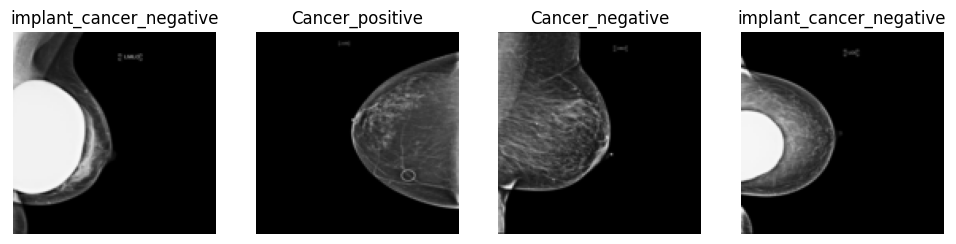

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

### Data Augmentation

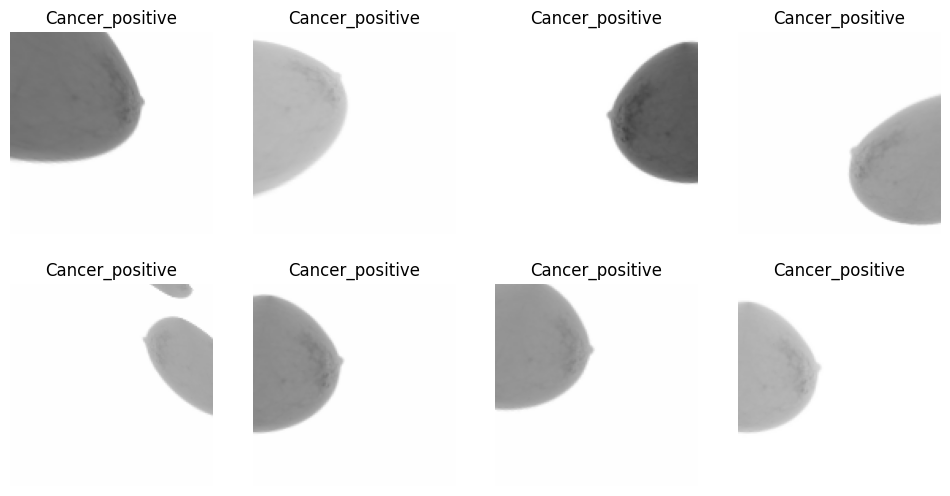

In [ ]:
bears = breast.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

##Training my classifier model (galaxies)

In [ ]:
bears = breast.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
from fastai.metrics import accuracy_multi, F1Score, Precision, Recall

In [ ]:
from fastai.callback import*

In [ ]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate, Precision(average='micro'),Recall(average='micro'),F1Score(average="macro")])
learn.recorder.train_metrics = True
learn.fit(3)
learn.fine_tune(100)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s]


epoch,train_loss,train_accuracy,train_error_rate,train_precision_score,train_recall_score,train_f1_score,valid_loss,valid_accuracy,valid_error_rate,valid_precision_score,valid_recall_score,valid_f1_score,time
0,2.490508,0.218750,0.781250,0.218750,0.218750,0.184819,1.305379,0.548387,0.451613,0.548387,0.548387,0.300676,00:17
1,2.416515,0.312500,0.687500,0.312500,0.312500,0.258770,1.261715,0.548387,0.451613,0.548387,0.548387,0.290385,00:02
2,2.307930,0.281250,0.718750,0.281250,0.281250,0.240535,1.275622,0.548387,0.451613,0.548387,0.548387,0.300000,00:01


epoch,train_loss,train_accuracy,train_error_rate,train_precision_score,train_recall_score,train_f1_score,valid_loss,valid_accuracy,valid_error_rate,valid_precision_score,valid_recall_score,valid_f1_score,time
0,1.648284,0.484375,0.515625,0.484375,0.484375,0.441548,1.218875,0.548387,0.451613,0.548387,0.548387,0.409804,00:02


epoch,train_loss,train_accuracy,train_error_rate,train_precision_score,train_recall_score,train_f1_score,valid_loss,valid_accuracy,valid_error_rate,valid_precision_score,valid_recall_score,valid_f1_score,time
0,1.447509,0.500000,0.500000,0.500000,0.500000,0.447747,1.163410,0.580645,0.419355,0.580645,0.580645,0.434402,00:02
1,1.360590,0.562500,0.437500,0.562500,0.562500,0.483755,1.115497,0.580645,0.419355,0.580645,0.580645,0.434402,00:01
2,1.467802,0.546875,0.453125,0.546875,0.546875,0.490531,1.099796,0.612903,0.387097,0.612903,0.612903,0.495116,00:01
3,1.457038,0.578125,0.421875,0.578125,0.578125,0.528321,1.104975,0.709677,0.290323,0.709677,0.709677,0.616667,00:01
4,1.472487,0.531250,0.468750,0.531250,0.531250,0.511147,1.146205,0.645161,0.354839,0.645161,0.645161,0.568727,00:01
5,1.458487,0.484375,0.515625,0.484375,0.484375,0.399186,1.169679,0.645161,0.354839,0.645161,0.645161,0.551136,00:01
6,1.447881,0.593750,0.406250,0.593750,0.593750,0.505879,1.184280,0.612903,0.387097,0.612903,0.612903,0.500379,00:01
7,1.469560,0.484375,0.515625,0.484375,0.484375,0.439749,1.199264,0.580645,0.419355,0.580645,0.580645,0.479912,00:01
8,1.480260,0.468750,0.531250,0.468750,0.468750,0.418050,1.217861,0.580645,0.419355,0.580645,0.580645,0.474104,00:01
9,1.425776,0.593750,0.406250,0.593750,0.593750,0.428029,1.247409,0.580645,0.419355,0.580645,0.580645,0.474104,00:02


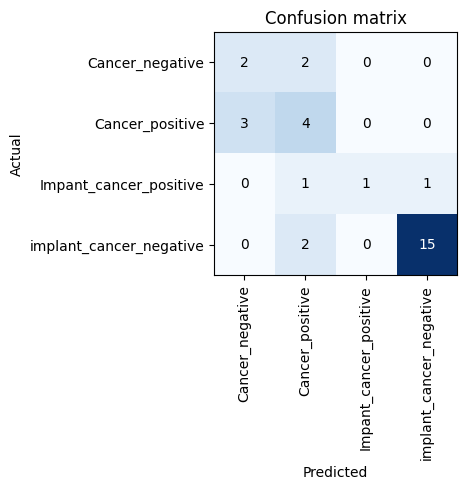

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

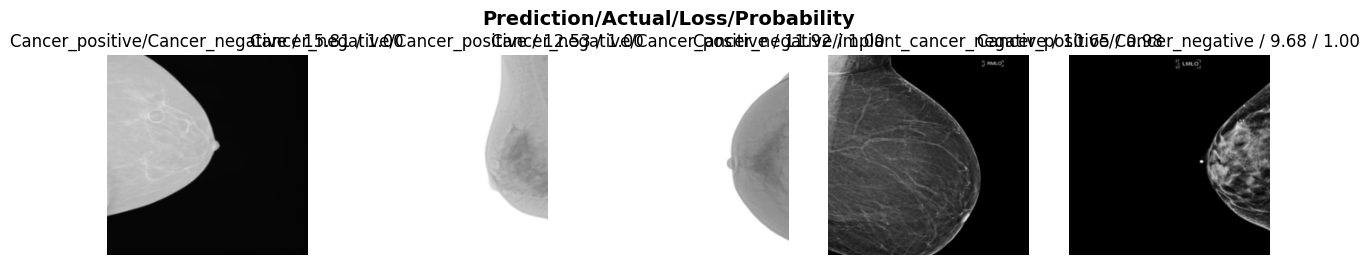

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *

### Cleaning the top losses

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Testing and turning the model into production

### Using the model for inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn = load_learner(path/'export.pkl')

#### Predicting an image

In [ ]:
learn.predict('great.jpeg')

('Cancer_negative',
 tensor(0),
 tensor([9.0082e-01, 9.9115e-02, 4.0707e-05, 1.9860e-05]))

#### Printing our target

In [ ]:
learn.dls.vocab

['Cancer_negative', 'Cancer_positive', 'Impant_cancer_positive', 'implant_cancer_negative']

## Creating a GUI in jupyter notebooks

#### Displaying thumbnail

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))


#### Creating a lebel

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = 'Please upload a galaxy image like the one above'
lbl_pred

Label(value='Please upload a galaxy image like the one above')

#### Button for action

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

###Event handlers

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Galaxy type: {pred} galaxy; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

### Creating a Vbox that contains widgets